In [25]:
import keras
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import rasterio
from scipy.ndimage import rotate
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
from keras.layers import Input, Dense, Activation, MaxPooling2D, Conv2D, BatchNormalization
from keras.layers import Concatenate, Cropping2D, Lambda
from keras.losses import categorical_crossentropy, binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd
import segmentation_models as sm

In [26]:
class ChickenDataGenerator(keras.utils.Sequence):
    def __init__(
        self,
        dataset_dir, # e.g. os.path.join(data_root, region, "train")
        batch_size,
        steps_per_epoch = None,
        shuffle=False,
        input_size=256,
        output_size=256,
        num_channels=4,
        num_classes=2,
        data_type="uint16",
        rotation=False
    ):
        """Initialization"""
        
        self.dataset_dir = dataset_dir

        self.batch_size = batch_size

        self.input_size = input_size
        self.output_size = output_size
    
        self.num_channels = num_channels
        self.num_classes = num_classes

        self.img_names = np.array(sorted(list(glob.glob(os.path.join(self.dataset_dir, "img", "*")))))
        self.mask_names = np.array(sorted(list(glob.glob(os.path.join(self.dataset_dir, "mask", "*")))))

        if steps_per_epoch is not None:
            self.steps_per_epoch = steps_per_epoch
        else:
            self.steps_per_epoch = len(self.img_names)//batch_size # ??? probably handle last batch size    

        self.shuffle = shuffle
        self.rotation = rotation

        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return self.steps_per_epoch

    def __getitem__(self, index):
        """Generate one batch of data"""
        indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        img_names = self.img_names[indices]
        mask_names = self.mask_names[indices]
        x_batch = np.zeros(
            (self.batch_size, self.input_size, self.input_size, self.num_channels),
            dtype=np.float32,
        )
        y_batch = np.zeros(
            (self.batch_size, self.output_size, self.output_size, self.num_classes),
            dtype=np.float32,
        )

        for i, (img_file, mask_file) in enumerate(zip(img_names, mask_names)):
            data = np.load(img_file).squeeze()
            data /= 255.0
            x_batch[i] = data[:,:,:self.num_channels]
            mask_data = np.load(mask_file)
            y_batch[i] = mask_data

        return x_batch, y_batch

    def on_epoch_end(self):
        self.indices = np.arange(len(self.img_names))
        if self.shuffle:
            np.random.shuffle(self.indices)


In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [27]:
data_root = "../../../../data/jason/train/balanced"
random_data_root = "../../../../data/jason/train/random"

region = "m_38075"

train_generator = ChickenDataGenerator(
    dataset_dir=os.path.join(data_root, region, "train"),
    batch_size=64
)   

In [5]:
test = train_generator[0]

In [25]:
img_names = train_generator.img_names
mask_names= train_generator.mask_names

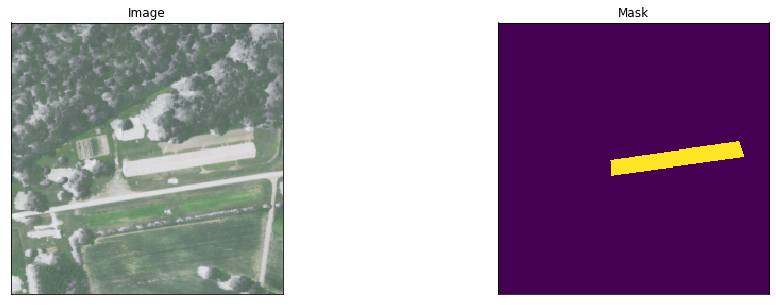

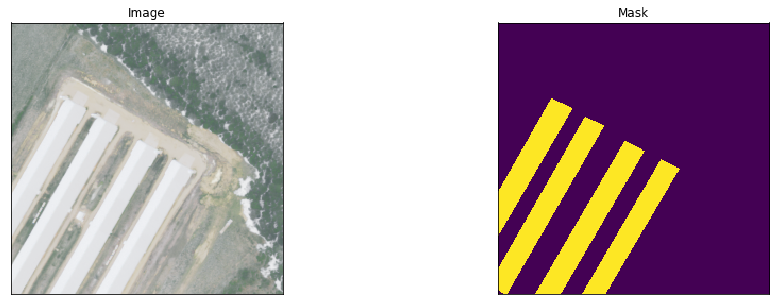

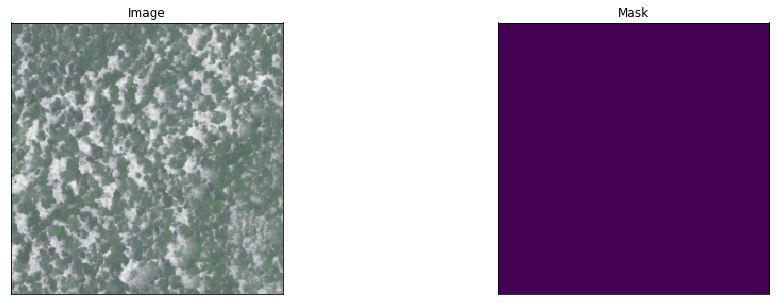

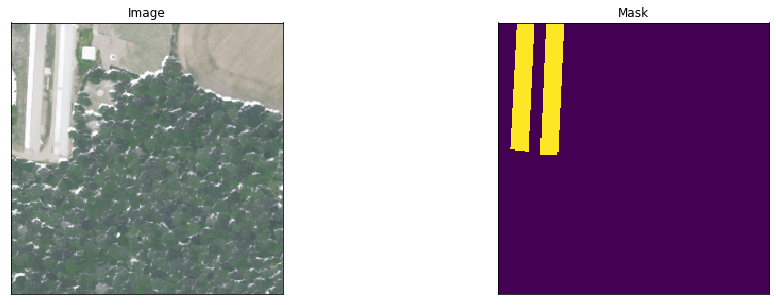

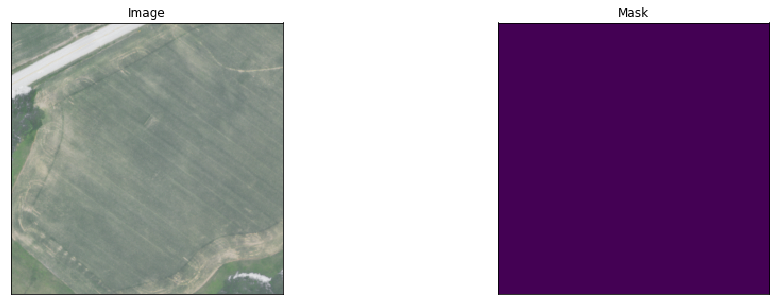

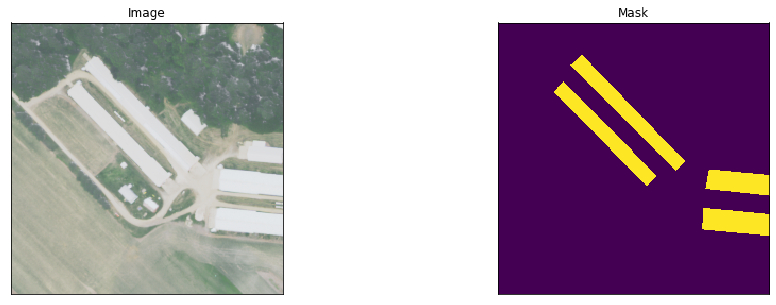

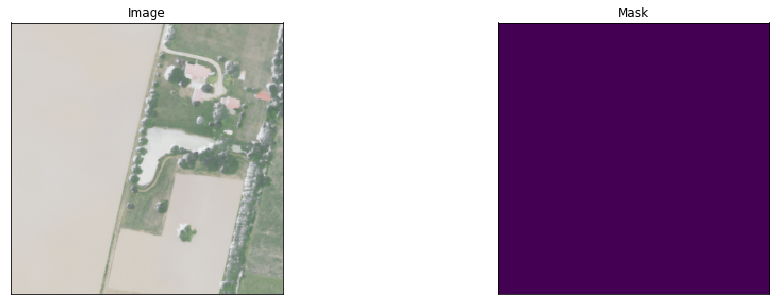

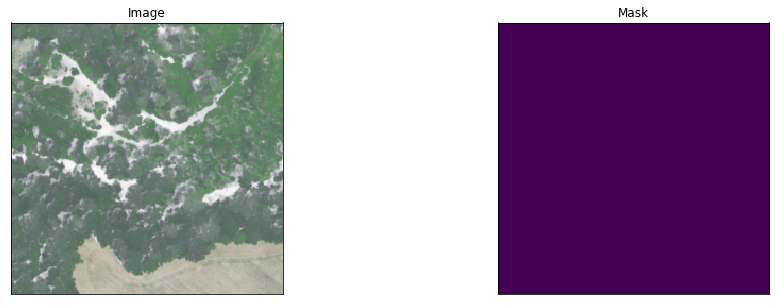

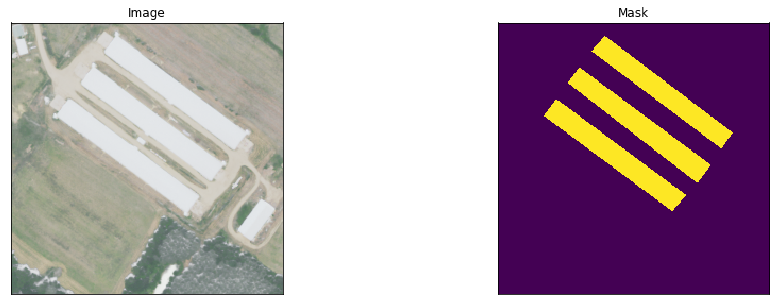

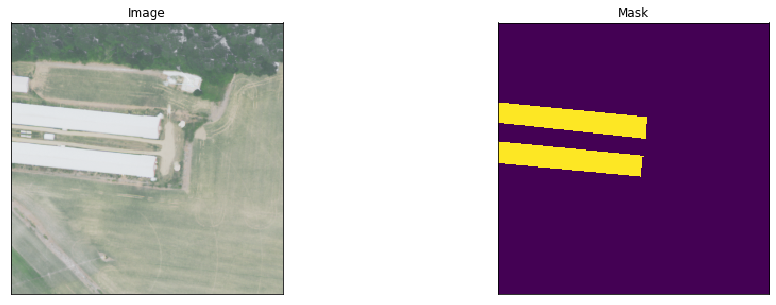

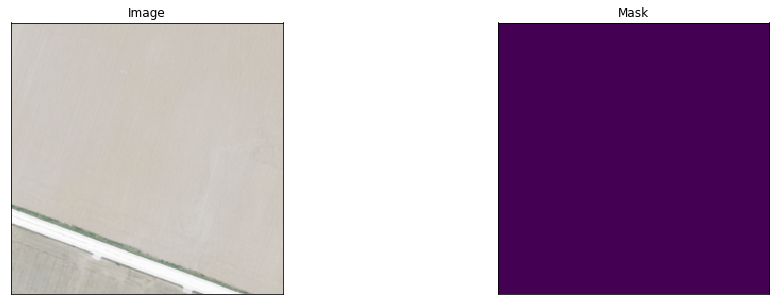

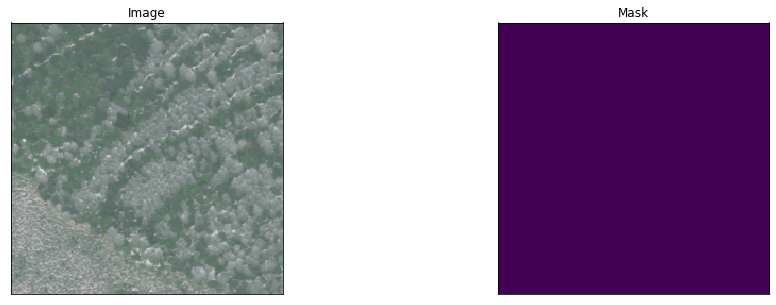

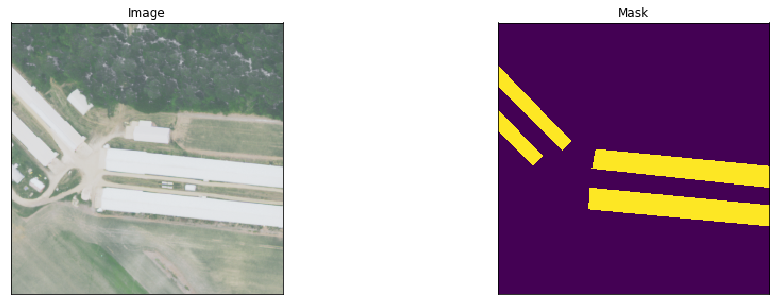

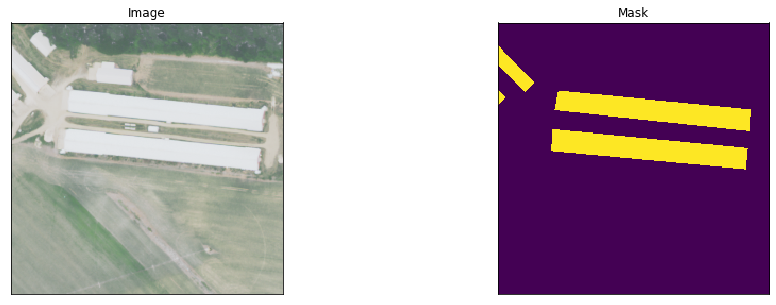

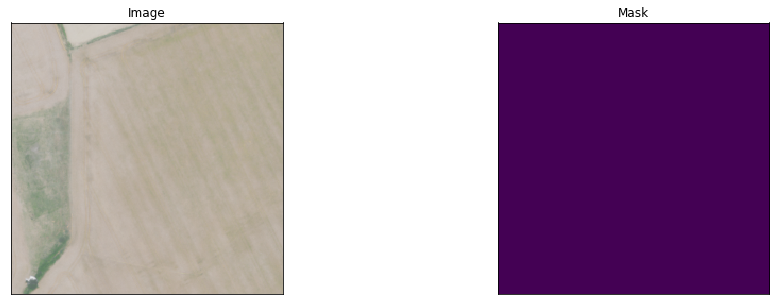

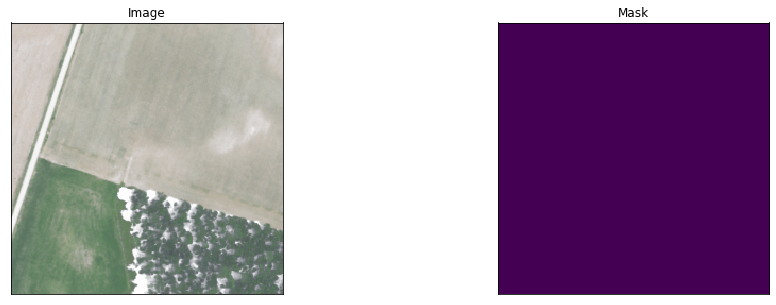

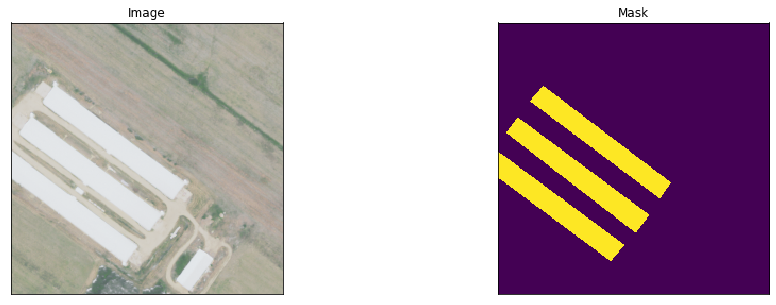

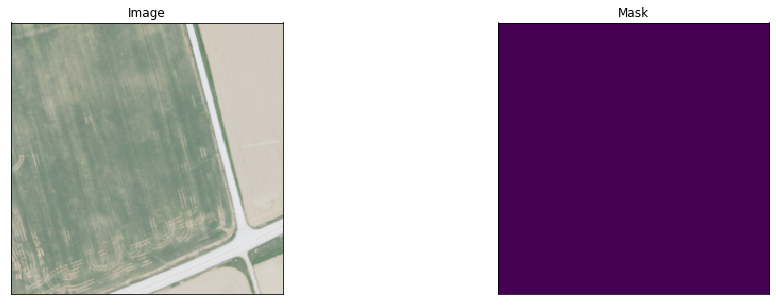

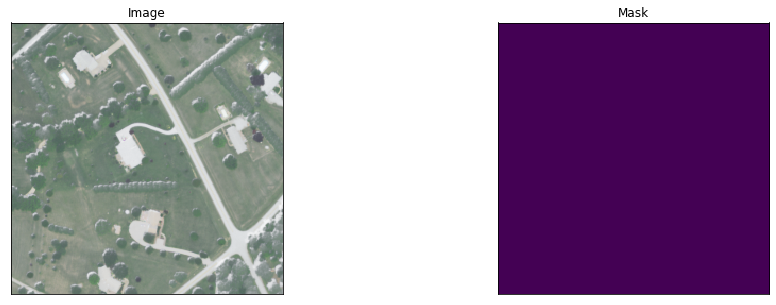

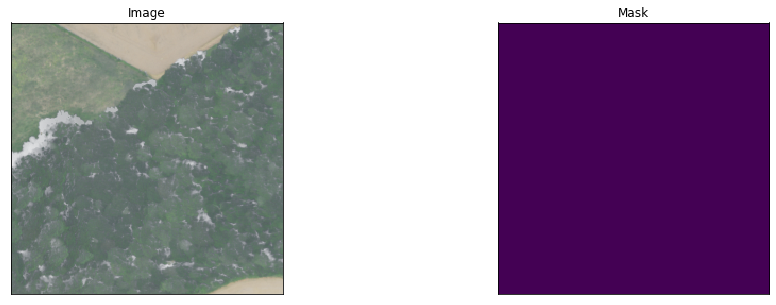

In [26]:
for i in range(20):
    visualize(image=test[0][i], mask=np.argmax(test[1][i],axis=2))

### Sanity check

In [182]:
np.all(np.argmax(target_one_hot,axis=2) == target)

True

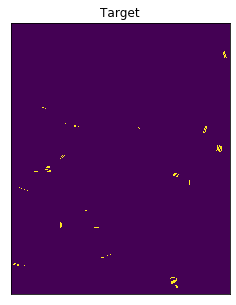

In [183]:
visualize(target=target)

In [190]:
# Randomly sample patch_size # of 256x256 patch per file

x = np.random.randint(width, data.shape[1]-width)
y = np.random.randint(height, data.shape[0]-height)

# Force to choose chicken house pixel for ~50% of data
# TODO switch to based on random coin flip
if len(x_ind) != 0 and np.random.randint(10) % 2 == 0:
    rand_index = np.random.randint(0,len(x_ind))
    x = x_ind[rand_index]
    y = y_ind[rand_index]

    temp_count = 0
    # If poultry house pixels out of bounds, random reselect pixel
    while not (x-width >= 0 and x+width < data.shape[1] and y-height >= 0 and y+height < data.shape[0]):
        rand_index = np.random.randint(0,len(x_ind))
        x = x_ind[rand_index]
        y = y_ind[rand_index]
        temp_count += 1
        if (temp_count > 5):
            x = np.random.randint(width, data.shape[1]-width)
            y = np.random.randint(height, data.shape[0]-height)

# Reselect until x is new pixel
while x in used_x:
    x = np.random.randint(width, data.shape[1]-width)
    y = np.random.randint(height, data.shape[0]-height)

used_x.add(x)

# Set up x_batch with img data at y,x coords
img = data[y-(height//2):y+(height//2), x-(width//2):x+(width//2), :].astype(np.float32)

# remove this
# x_batches[count] = img

# 256 x 256 x (4 + 2)
# data = np.random.randint(0, 255, (10,10)).astype(np.uint8)
# im = Image.fromarray(data)
# im.save('test.tif')

# TODO store img in file for count

# FOR DENSE
mask = target_one_hot[y-(height//2):y+(height//2), x-(width//2):x+(width//2)]

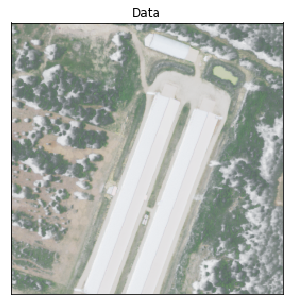

In [191]:
visualize(data=data[y-(height//2):y+(height//2), x-(width//2):x+(width//2), :])

In [195]:
temp_mask = np.argmax(mask,axis=2)

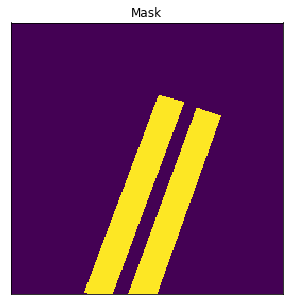

In [197]:
visualize(mask = temp_mask)

# Evaluation

In [43]:
def get_metrics(y_pred, gt):
    y_pred = y_pred.astype(int)
    y_pred = y_pred.squeeze()
    
    y_true = np.array(gt)
    y_true = y_true.squeeze()
    
    uniq = np.unique(y_true)
    
    if (len(uniq) == 1):
        return {"IOU": 1.0, "Accuracy": 1.0, "Precision": 1.0, "Recall": 1.0}
    
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    assert tp + tn + fp + fn == y_true.size

    n = tp + fp + tn + fn

    acc = (tp+tn)/n
    recall = (tp/(tp+fn))
    precision = tp / (tp + fp)
    iou = tp /(tp + fn + fp)

    print("IOU: {}".format(iou))
    print("Accuracy: {}".format(acc))
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    return {"IOU": iou, "Accuracy": acc, "Precision": precision, "Recall": recall}

In [6]:
def get_model():
    # K.clear_session()
    model = sm.Unet(input_shape=(None,None,4), classes = 2, activation='softmax', encoder_weights=None)

    optimizer = Adam(lr=0.0001)

    metrics = [sm.metrics.IOUScore(class_indexes=1), sm.metrics.FScore(beta=1), sm.metrics.Precision(class_indexes=1), sm.metrics.Recall(class_indexes=1)]

    bceLoss = sm.losses.BinaryCELoss()

    model.compile(loss=bceLoss, optimizer=optimizer, metrics=metrics)
    
    return model

In [7]:
test_data_root = "../../../../data/jason/test/random"

region = "m_38075"

test_generator = ChickenDataGenerator(
    dataset_dir=os.path.join(data_root, region, "test"),
    batch_size=64
)

In [8]:
# Load model
model = get_model()

/home/jason/anaconda3/lib/python3.7/site-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


In [9]:
model.load_weights('../../../../data/jason/m_38075_exp/random/unet_model_35_0.00.h5')

In [13]:
for i, (data,img) in enumerate(test_generator):
    if i==2:
        break
    res = model.predict(data)
    for idx in range(res.shape[0]):
        ground_truth = img[idx]

        visualize(res = np.argmax(res[idx],axis=2), ground_truth = np.argmax(ground_truth,axis=2))
        get_metrics(np.argmax(res[idx],axis=2), np.argmax(ground_truth,axis=2))



(64, 256, 256, 2)


KeyboardInterrupt: 

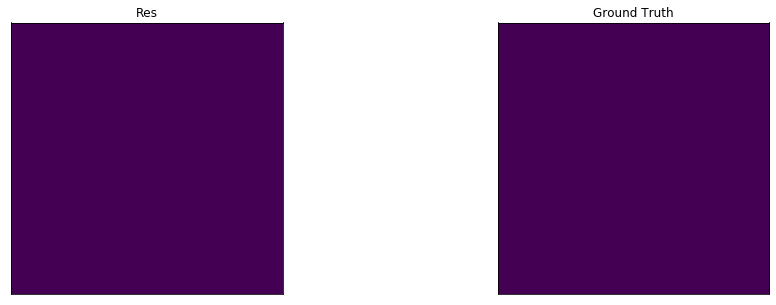

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


/home/jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars
/home/jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/home/jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


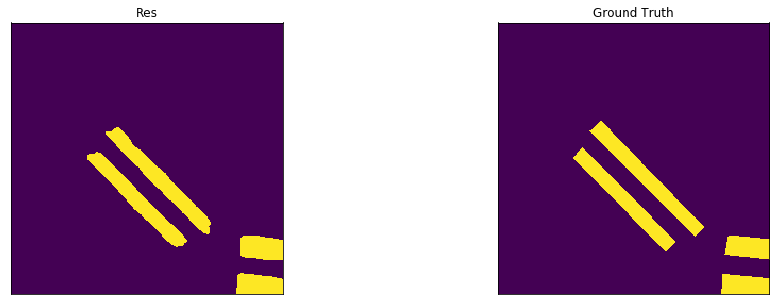

IOU: 0.8759231905465288
Accuracy: 0.98974609375
Precision: 0.9446435682994823
Recall: 0.9233164655507979


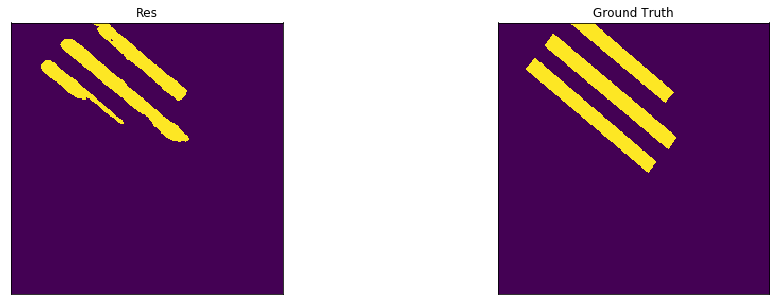

IOU: 0.6646879240162822
Accuracy: 0.9698333740234375
Precision: 0.9698094531056669
Recall: 0.6787322480083131


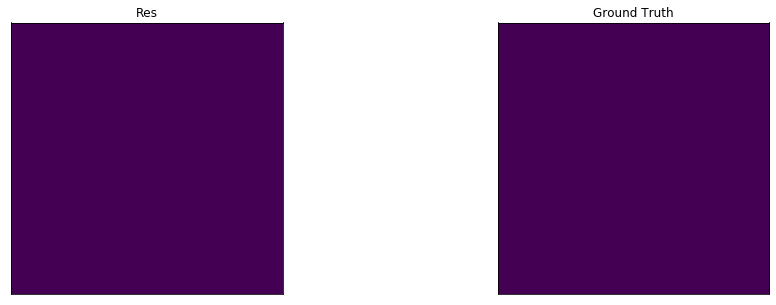

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


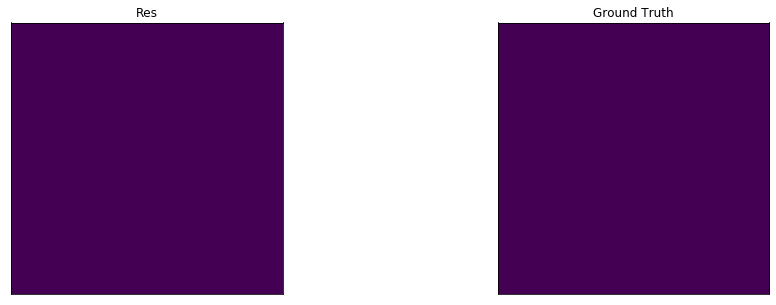

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


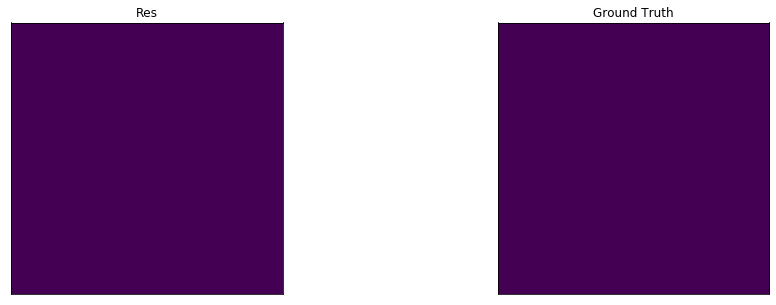

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


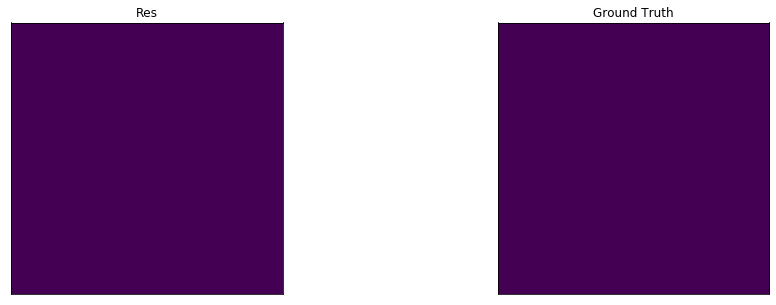

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


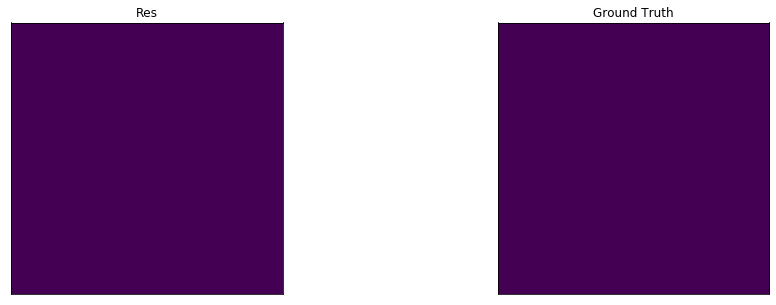

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


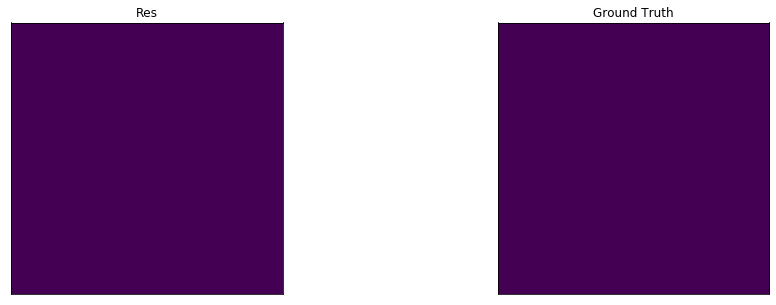

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


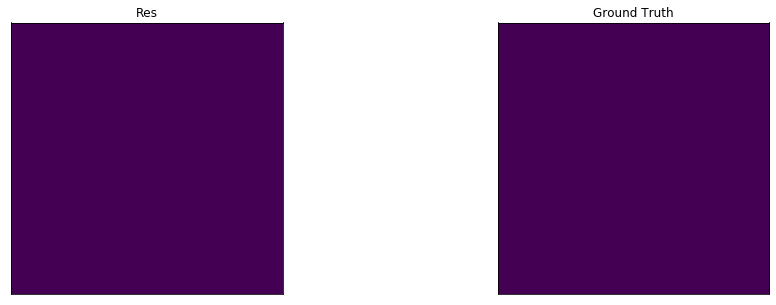

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


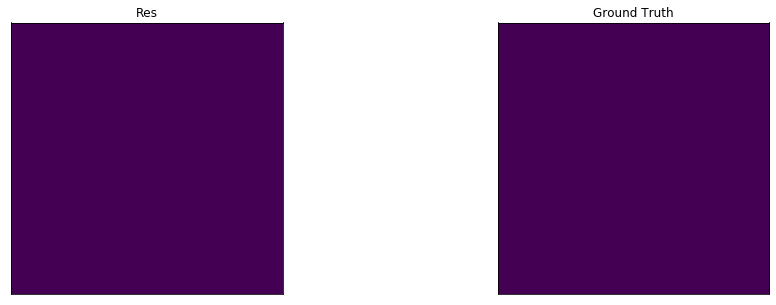

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


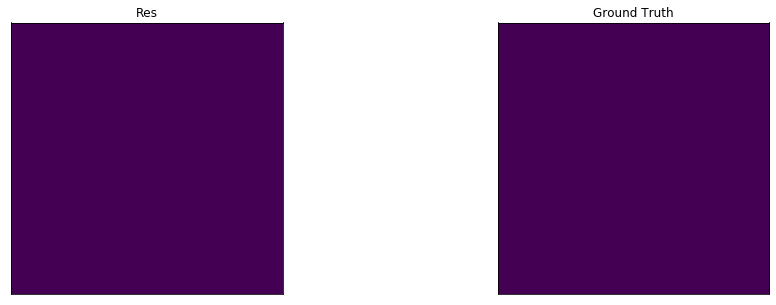

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


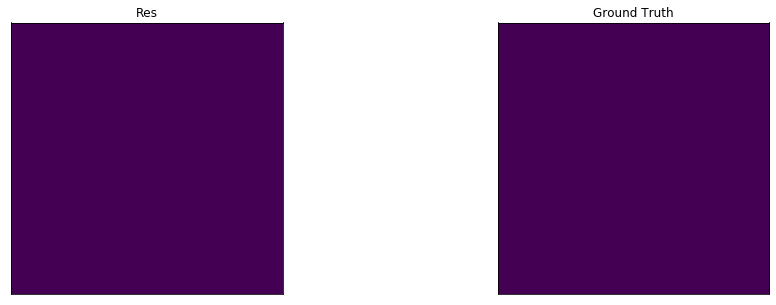

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


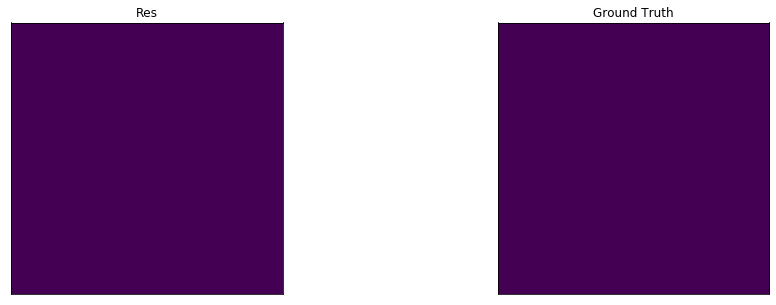

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


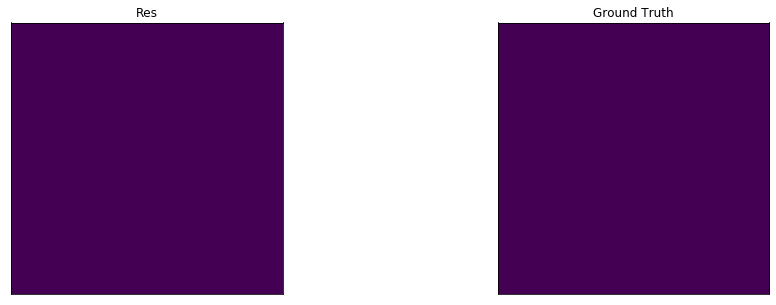

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


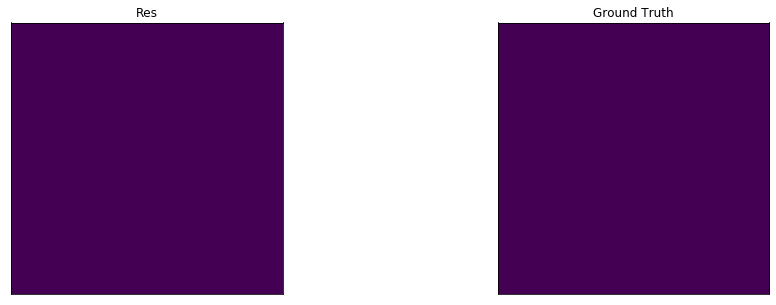

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


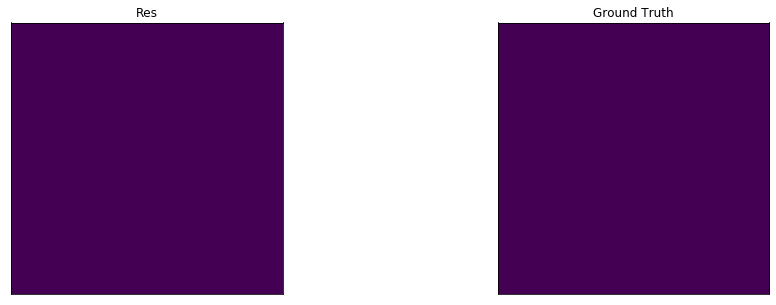

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


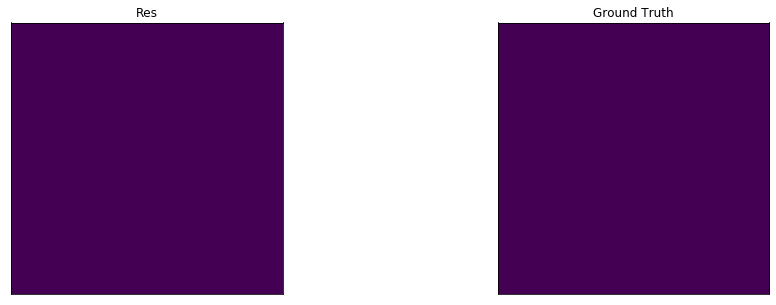

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


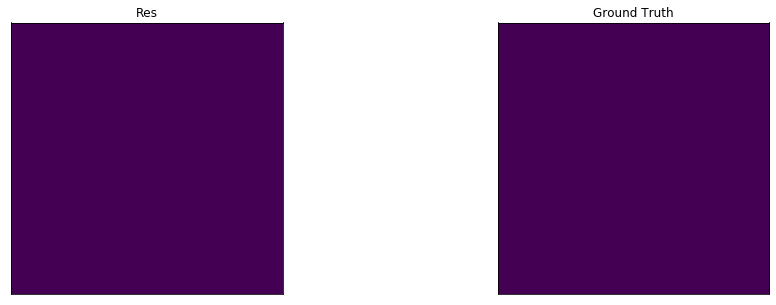

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


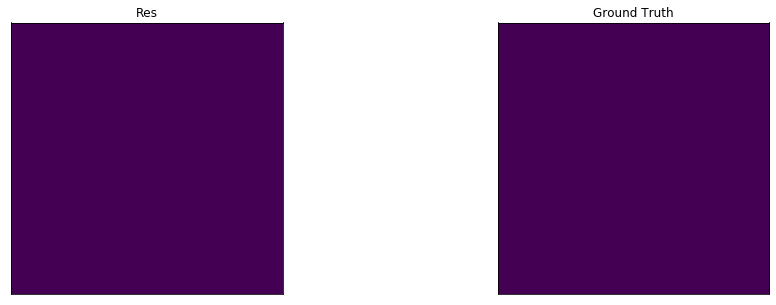

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


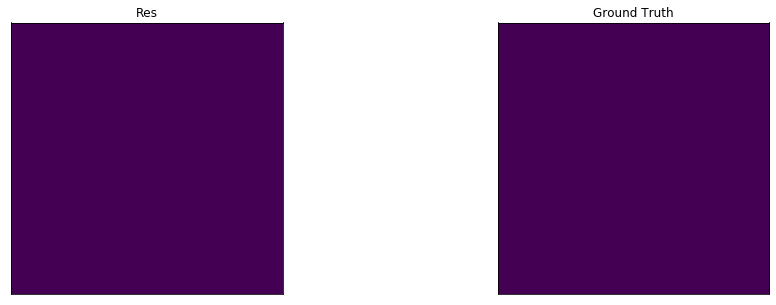

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


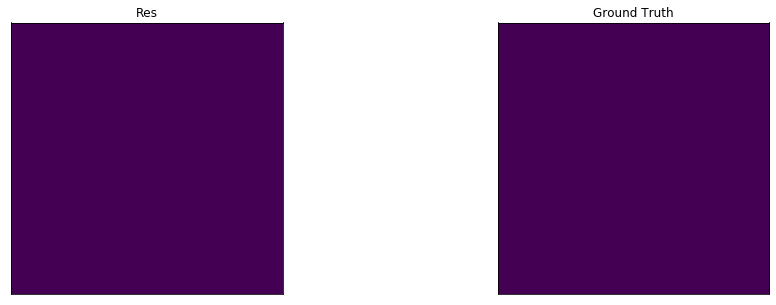

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


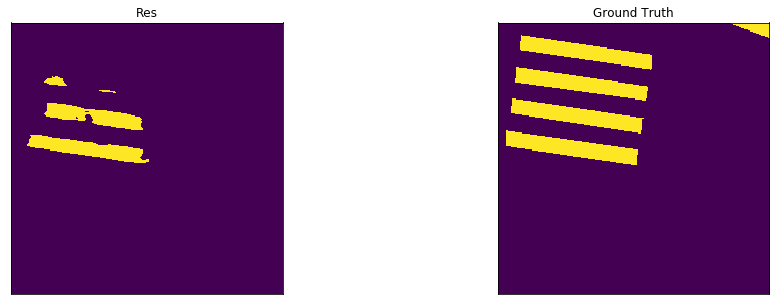

IOU: 0.3660341811330911
Accuracy: 0.9281158447265625
Precision: 0.9992652461425422
Recall: 0.36613272311212813


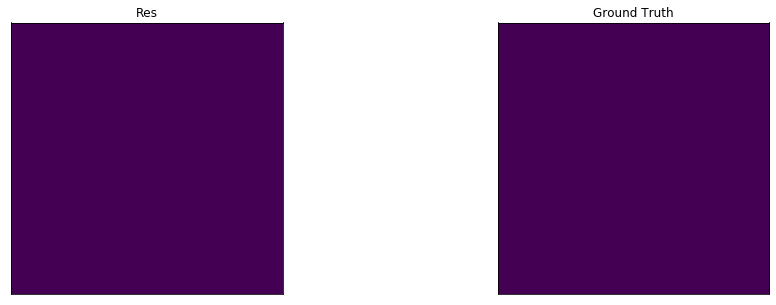

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


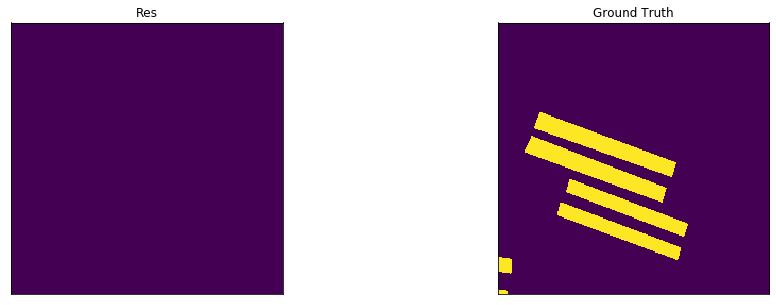

IOU: 0.0
Accuracy: 0.8845367431640625
Precision: nan
Recall: 0.0


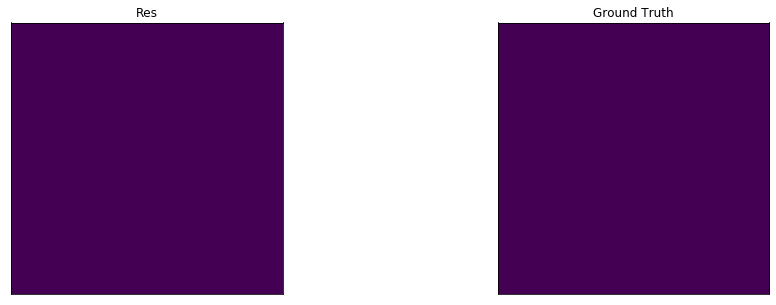

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


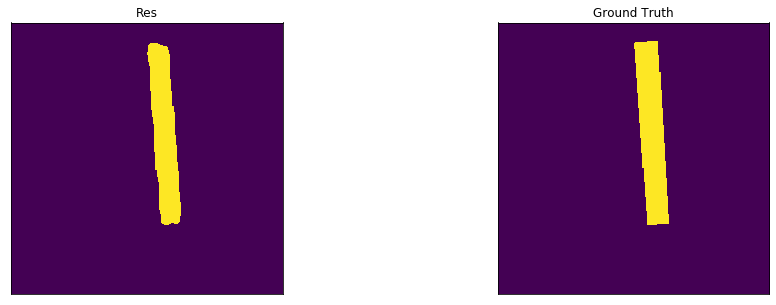

IOU: 0.8961558996262681
Accuracy: 0.9940643310546875
Precision: 0.9979191438763377
Recall: 0.8978336453597219


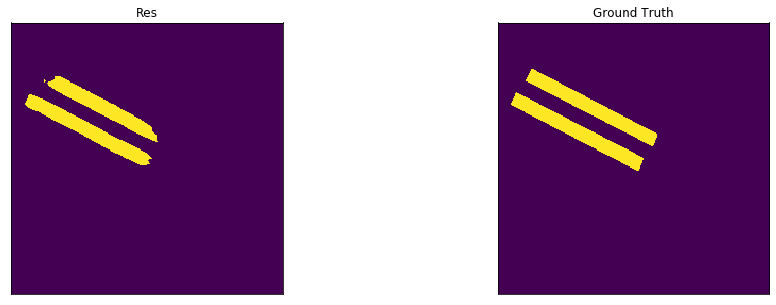

IOU: 0.8242985562517026
Accuracy: 0.9901580810546875
Precision: 0.9630808402291534
Recall: 0.8511954992967651


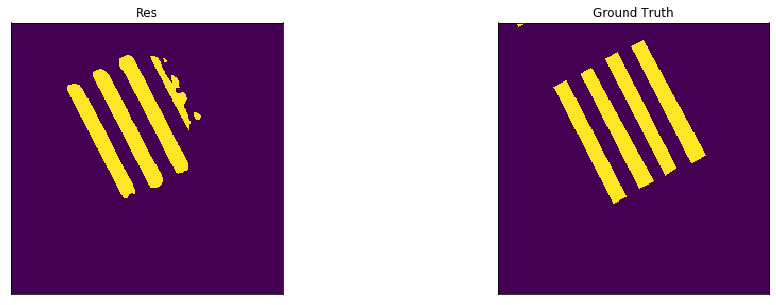

IOU: 0.738170782176852
Accuracy: 0.971038818359375
Precision: 0.9353259919594477
Recall: 0.777874691088821


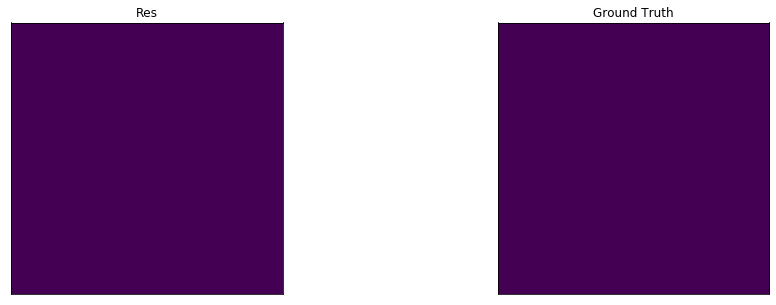

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


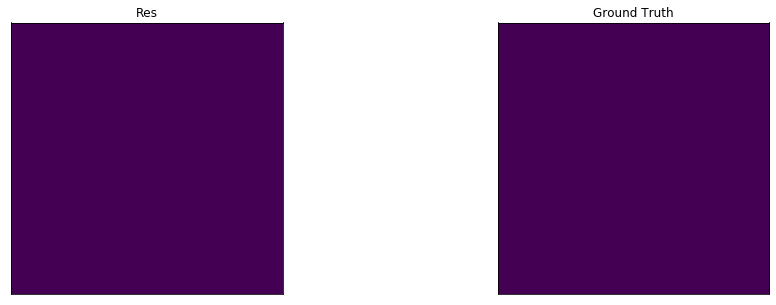

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


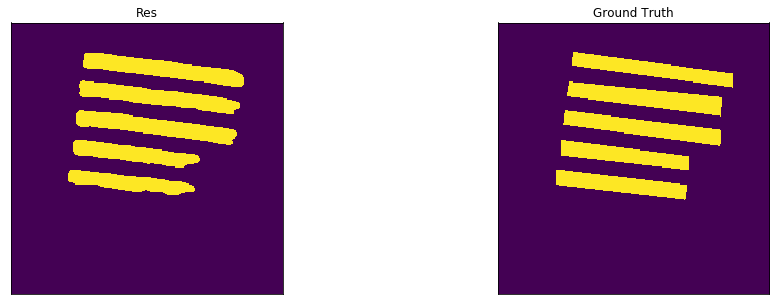

IOU: 0.8393641888733053
Accuracy: 0.973785400390625
Precision: 0.9198688390203914
Recall: 0.9055785332391809


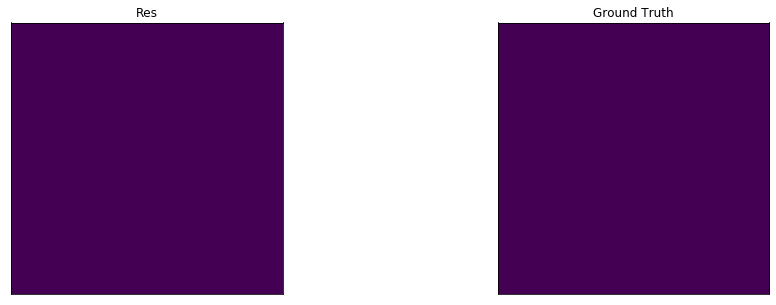

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


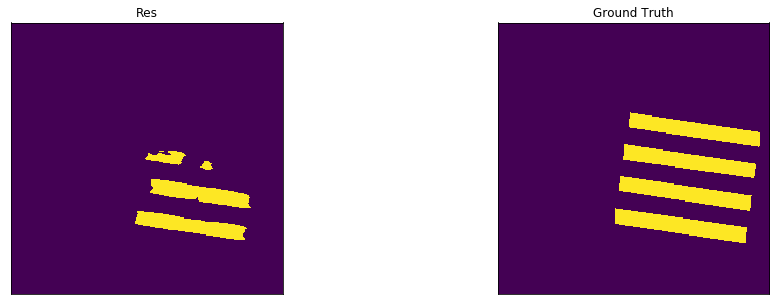

IOU: 0.42592592592592593
Accuracy: 0.93756103515625
Precision: 0.9960629921259843
Recall: 0.4266441821247892


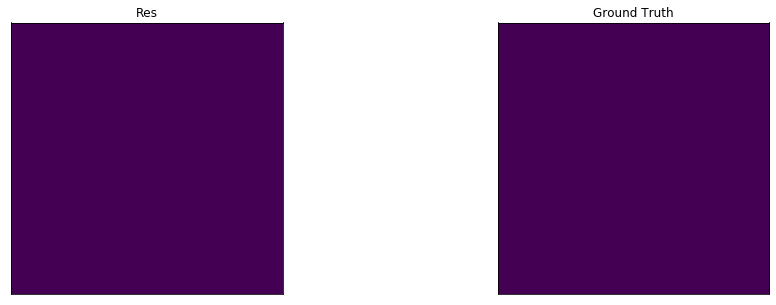

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


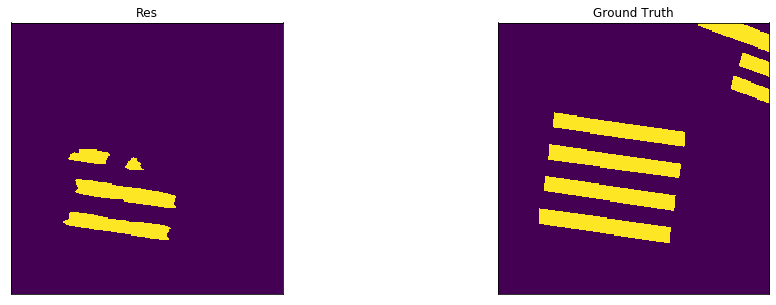

IOU: 0.3480408667340294
Accuracy: 0.9113922119140625
Precision: 0.9974259974259975
Recall: 0.34835374761209126


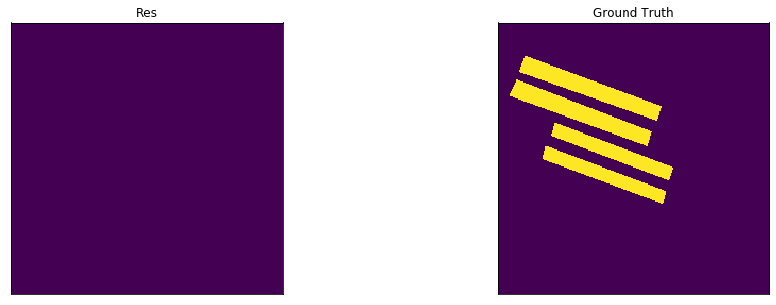

IOU: 0.0
Accuracy: 0.887847900390625
Precision: nan
Recall: 0.0


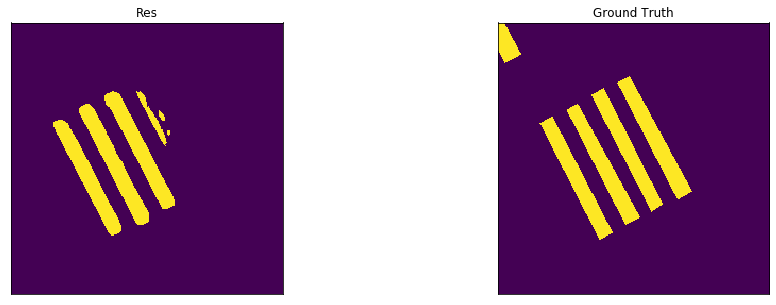

IOU: 0.6568437378829004
Accuracy: 0.9594879150390625
Precision: 0.929407461594733
Recall: 0.6913345123112502


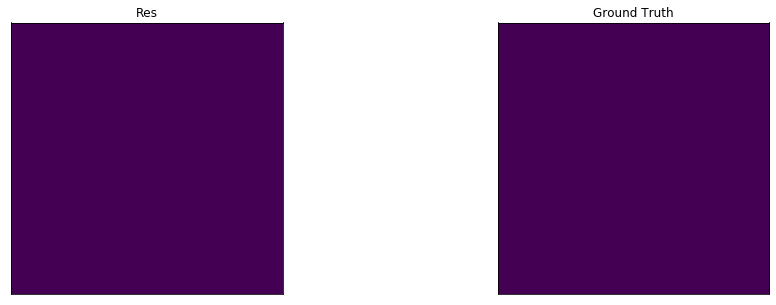

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


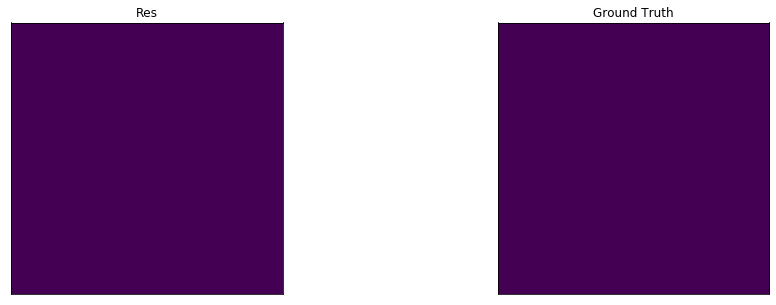

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


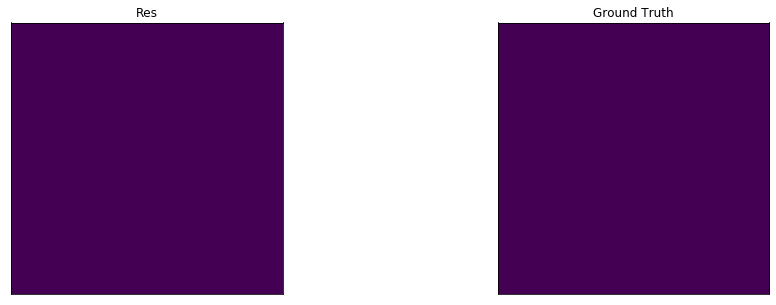

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


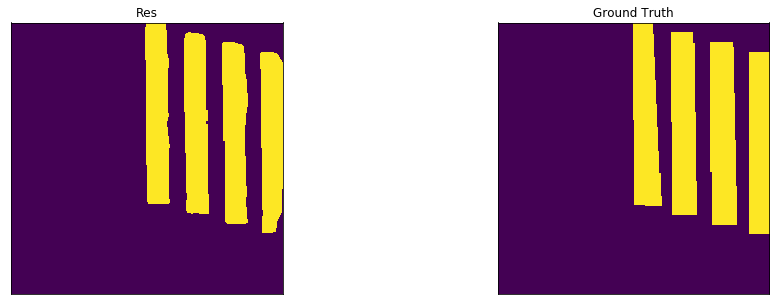

IOU: 0.8979684854798802
Accuracy: 0.9760894775390625
Precision: 0.9828950181740432
Recall: 0.9122238391321603


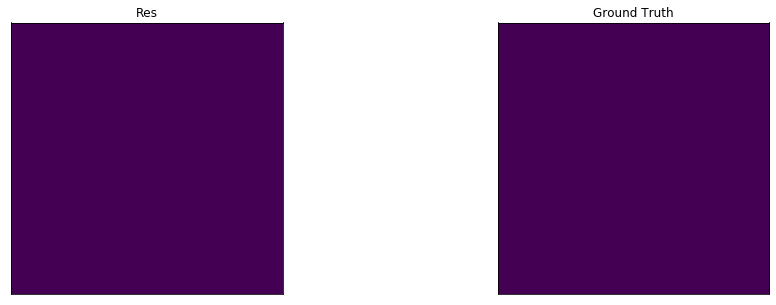

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


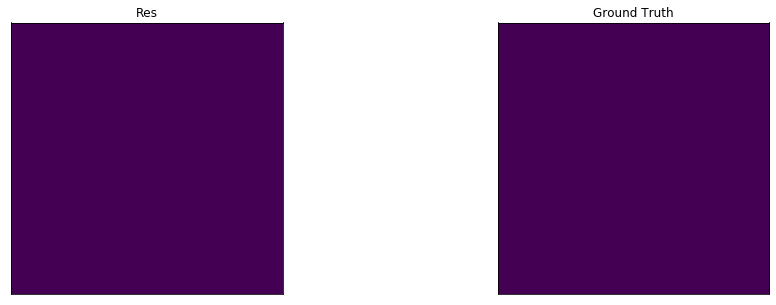

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


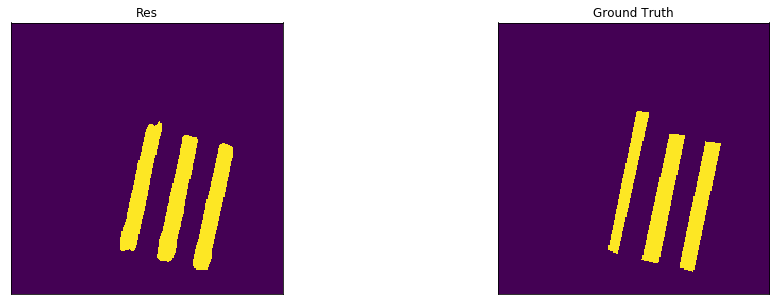

IOU: 0.7969042354141861
Accuracy: 0.981781005859375
Precision: 0.8621641516378359
Recall: 0.9132553606237817


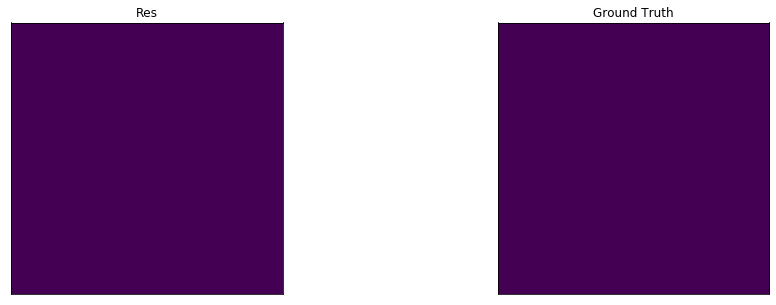

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


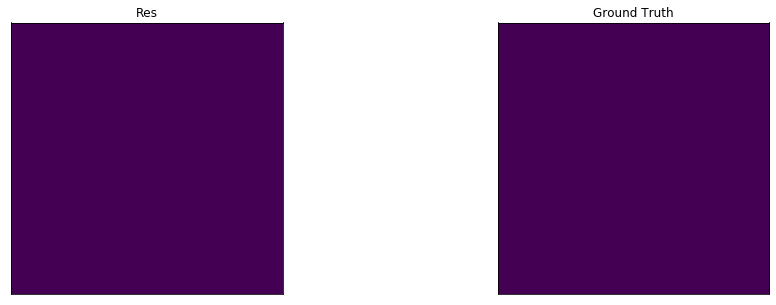

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


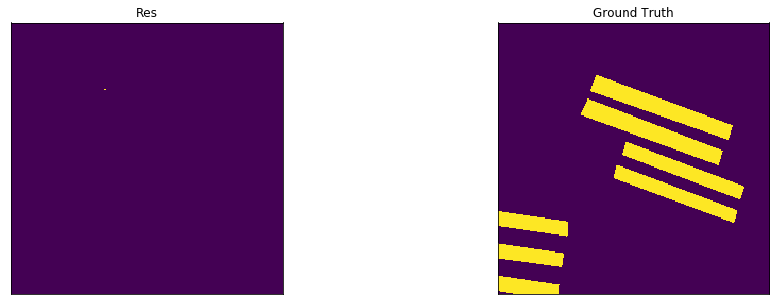

IOU: 0.00010166734444896299
Accuracy: 0.8499298095703125
Precision: 1.0
Recall: 0.00010166734444896299


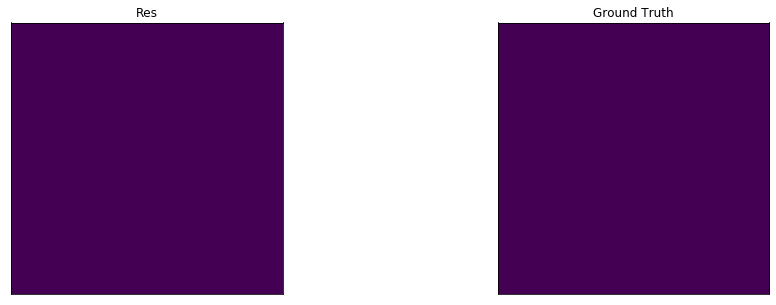

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


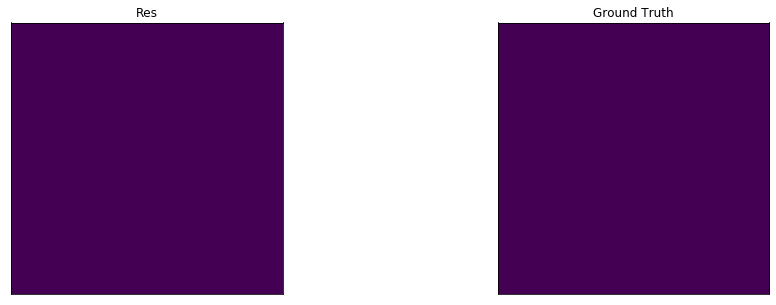

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


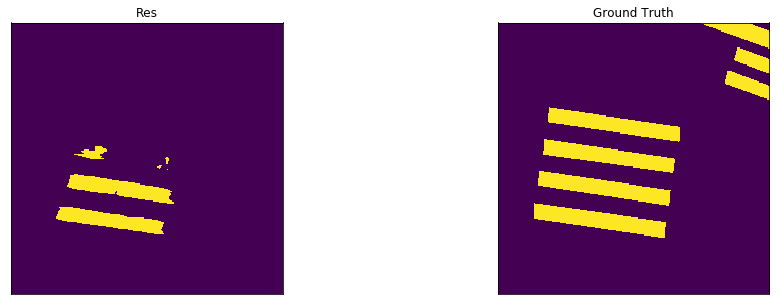

IOU: 0.31925410020220174
Accuracy: 0.90753173828125
Precision: 0.9985945186226283
Recall: 0.3193976174421218


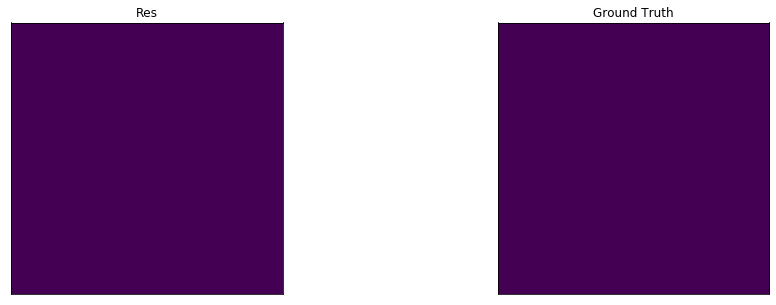

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


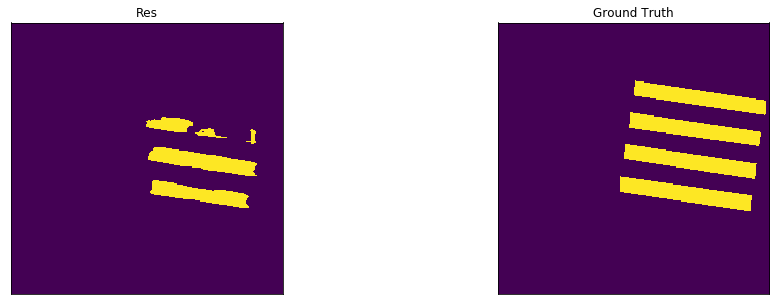

IOU: 0.4501891551071879
Accuracy: 0.94012451171875
Precision: 0.9935064935064936
Recall: 0.4515177065767285


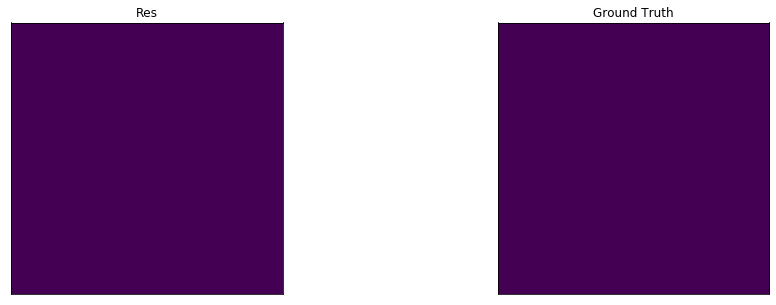

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


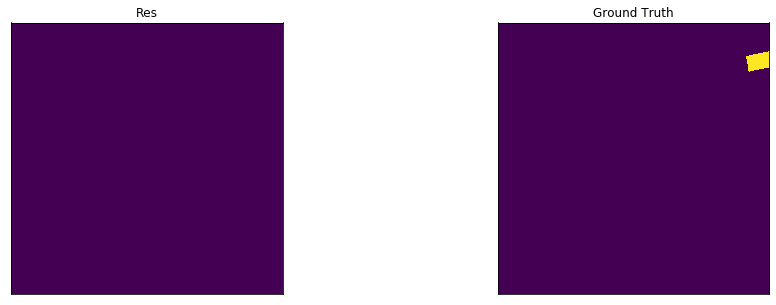

IOU: 0.0
Accuracy: 0.994964599609375
Precision: nan
Recall: 0.0


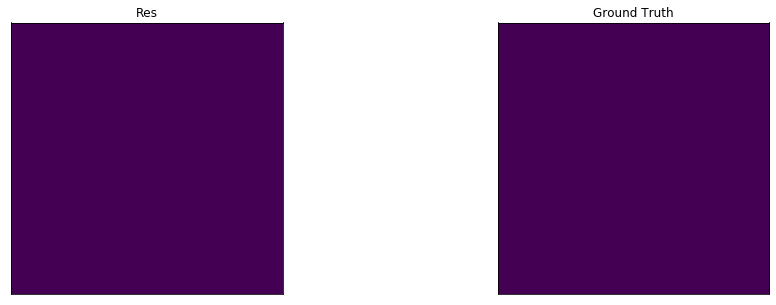

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


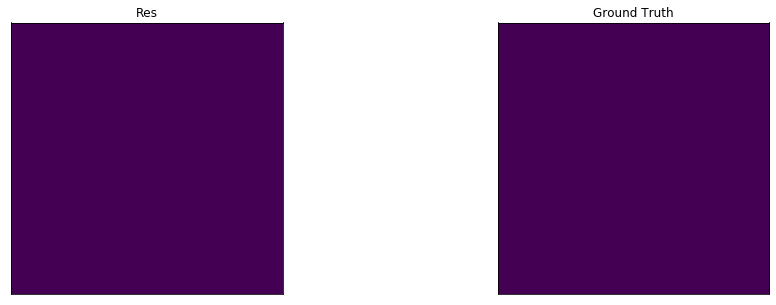

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


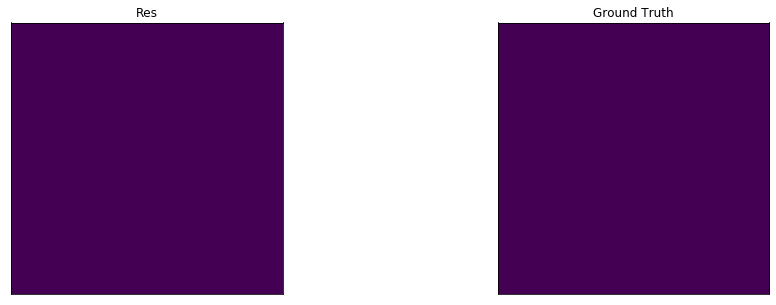

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


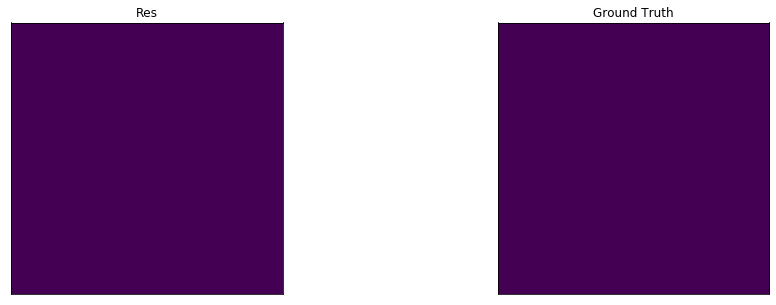

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


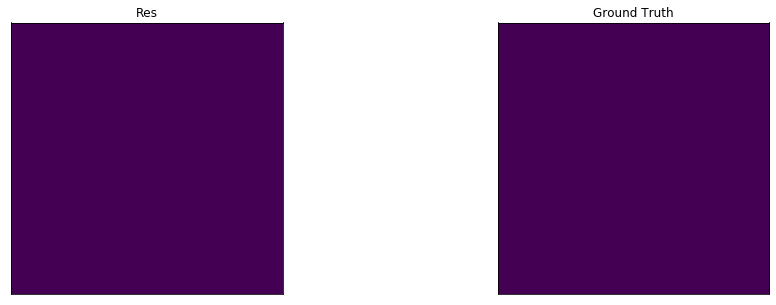

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


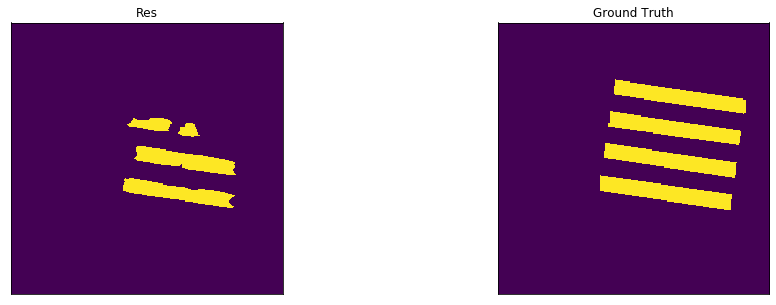

IOU: 0.45133239831697053
Accuracy: 0.9403076171875
Precision: 0.9956683168316832
Recall: 0.4522203485103991


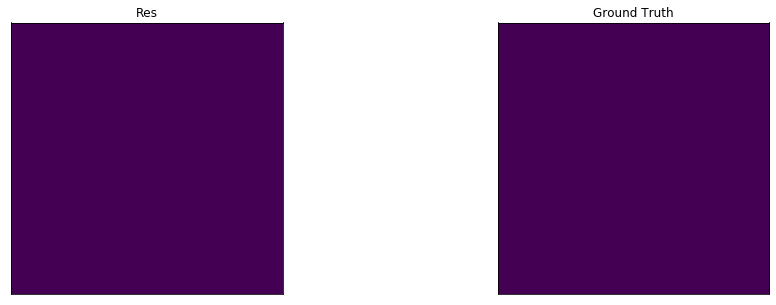

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


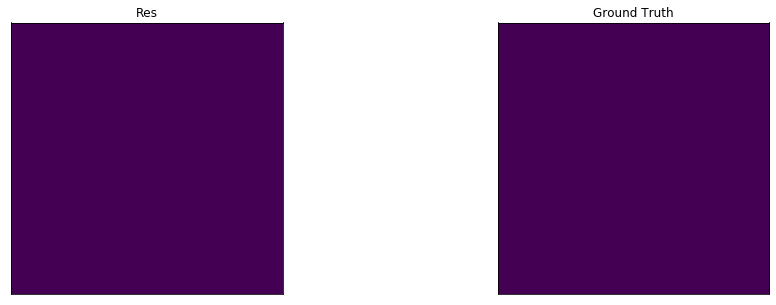

IOU: nan
Accuracy: 1.0
Precision: nan
Recall: nan


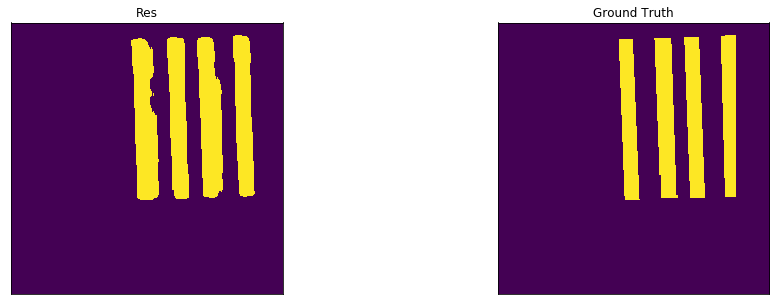

IOU: 0.7809542021225738
Accuracy: 0.9650421142578125
Precision: 0.79633421078288
Recall: 0.9758661887694146


In [24]:
for idx in range(res.shape[0]):
    ground_truth = img[idx]
    
    visualize(res = np.argmax(res[idx],axis=2), ground_truth = np.argmax(ground_truth,axis=2))
    get_metrics(np.argmax(res[idx],axis=2), np.argmax(ground_truth,axis=2))
        

# testing eval spec

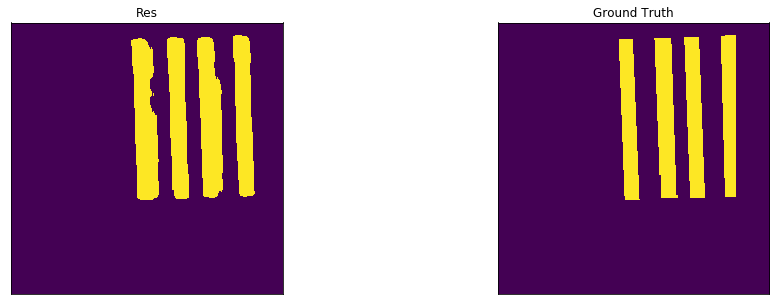

In [45]:
visualize(res = np.argmax(res[idx],axis=2), ground_truth = np.argmax(ground_truth,axis=2))

In [44]:
get_metrics(np.argmax(res[idx],axis=2), np.argmax(ground_truth,axis=2))

IOU: 0.7809542021225738
Accuracy: 0.9650421142578125
Precision: 0.79633421078288
Recall: 0.9758661887694146


{'IOU': 0.7809542021225738,
 'Accuracy': 0.9650421142578125,
 'Precision': 0.79633421078288,
 'Recall': 0.9758661887694146}